# 人の顔の生成
Kaggleのcelebaデータセットを用いて、新たな顔をDCGANで生成。環境上の問題より、Google ColabにてGPUを使用しての実装となった。

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import time

from IPython import display

In [ ]:
# Google Driveをマウント
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# 元の画像サイズは218x178
# サイズを正方形に加工し、64x64に縮小
# サンプル数も20万を超えていたため、5万を今回使用
images = np.load('/content/gdrive/My Drive/Data/celebs_resize.npz')
train_images = np.array(images['arr_0']).reshape(50000, 64, 64, 3)

#画像サイズ
print('画像サイズ', train_images[0].shape)

画像サイズ (64, 64, 3)


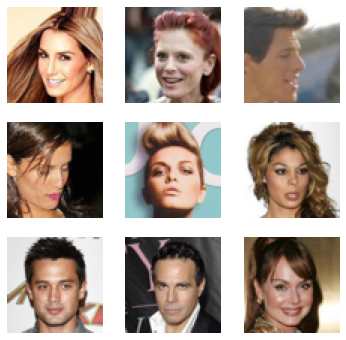

In [ ]:
fig = plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_images[i])
    plt.axis('off')

In [ ]:
train_images = np.array(train_images).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## モデル実装

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) # 出力サイズの確認（noneはバッチサイズ）
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) 
                             
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

## Loss and Optimizer

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Save Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Train

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# コンパイルを行わずともコードを実行できる（よりPythonic）。高速化が図れる
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(tf.cast((predictions[i, :, :, :] * 127.5 + 127.5), 'int64'))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
K.clear_session()

generator = make_generator_model()
discriminator = make_discriminator_model()

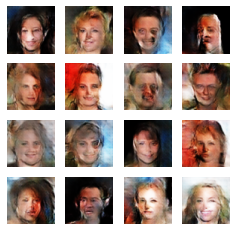

In [ ]:
#@title Default title text
EPOCHS = 400 #@params
noise_dim = 100 #@params
num_examples_to_generate = 16 #@params

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

train(train_dataset, EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

Epoch:400までの推移


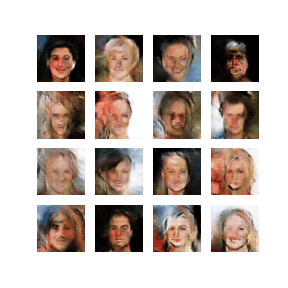

In [1]:
from IPython.display import Image
print('Epoch:400までの推移')
Image('/Users/tamiyagt/Documents/Machine Learning/01_github/diveintocode-ml/sprint/dcgan_celeb.gif')

>輪郭や顔のパーツは判別できたが、まだかなりぼやけている（ピカソチック…）。より線などをはっきりさせるため、WGANの実装が効果的か。

## おまけ：新種ポケモンの生成

In [ ]:
# ZIPからデータを抽出し、RGBに変換（元はP）
# 画像はネットから拾ったもの
# サンプル数は649（第五世代まで）
import zipfile

pkmn_images = []
with zipfile.ZipFile('/content/gdrive/My Drive/Data/PKMN_BW.zip', 'r') as f:
  f.extractall('/content/gdrive/My Drive/Data/PKMN_BW')
  BASE_PATH = '/content/gdrive/My Drive/Data/PKMN_BW/'
  for image in os.listdir(BASE_PATH):
    if '.png' in image:
      im = PIL.Image.open(BASE_PATH+image).getdata()
      im_rgb = im.convert('RGB')
      pkmn_images.append(im_rgb)

In [ ]:
pkmn_images = np.array(pkmn_images).reshape(649, 96, 96, 3)

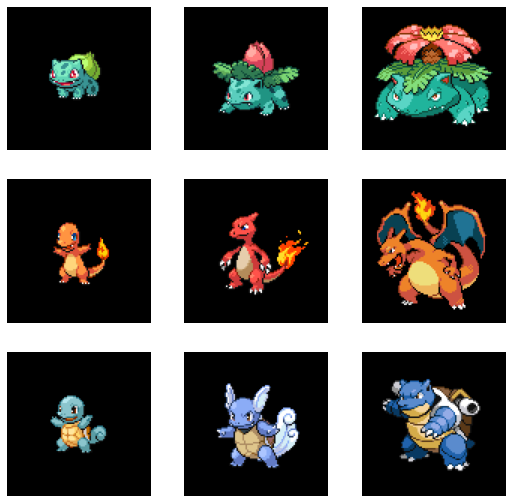

In [ ]:
fig = plt.figure(figsize=(9,9))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(pkmn_images[i])
    plt.axis('off')

In [ ]:
train_images = np.array(pkmn_images).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# モデル構築
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(12*12*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((12, 12, 256)))
    assert model.output_shape == (None, 12, 12, 256) # 出力サイズの確認（noneはバッチサイズ）
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 12, 12, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 24, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 48, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 96, 96, 3)

    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[96, 96, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) 
                             
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
K.clear_session()

generator = make_generator_model()
discriminator = make_discriminator_model()

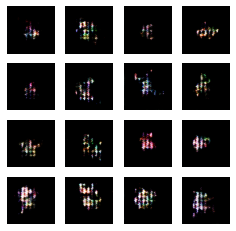

In [ ]:
#@title Default title text
EPOCHS = 5000 #@params
noise_dim = 100 #@params
num_examples_to_generate = 16 #@params

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

train(train_dataset, EPOCHS)

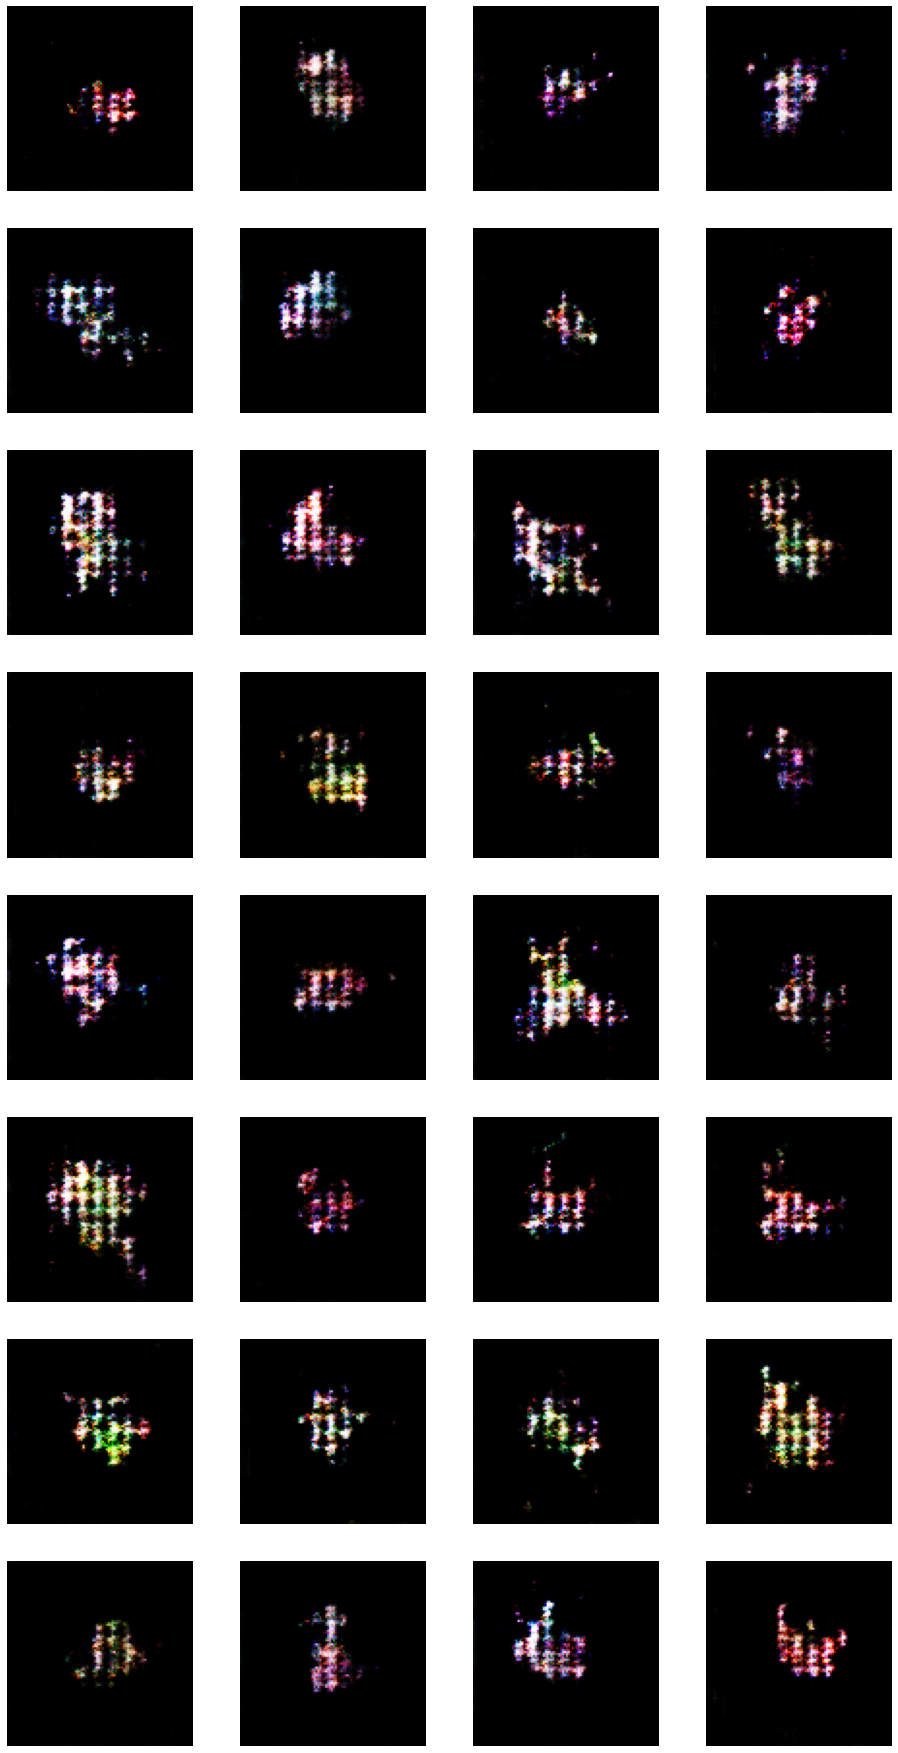

In [ ]:
noise = tf.random.normal([32, 100])

predictions = generator(noise, training=False)

fig = plt.figure(figsize=(16,32))

for i in range(predictions.shape[0]):
    plt.subplot(8, 4, i+1)
    plt.imshow(tf.cast((predictions[i, :, :, :] * 127.5 + 127.5), 'int64'))
    plt.axis('off')

plt.savefig('PKMN_GAN_epoch_5000')
plt.show()

>輪郭がはっきりとしておらず、かなりスライムっぽい。<br>
>初期層を12x12の半分である6x6に変更し、１層増やして再度学習を行なってみる。

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(6*6*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((6, 6, 512)))
    
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[96, 96, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')) 
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
K.clear_session()

generator = make_generator_model()
discriminator = make_discriminator_model()

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 512

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

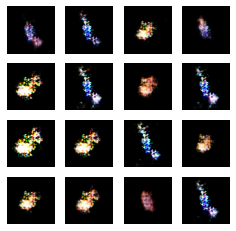

In [ ]:
EPOCHS = 5000 #@params
noise_dim = 100 #@params
num_examples_to_generate = 16 #@params

seed = tf.random.normal([num_examples_to_generate, noise_dim])

train(train_dataset, EPOCHS)

Epoch:5000までの推移


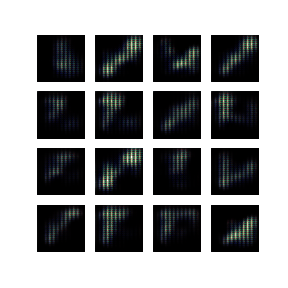

In [2]:
from IPython.display import Image
print('Epoch:5000までの推移')
Image('/Users/tamiyagt/Documents/Machine Learning/01_github/diveintocode-ml/sprint/dcgan_pkmn.gif')

>層を増やし、初期層のサイズを小さくすることによって結構生物っぽい形が生成された。ただ、顔は無く、手足もほとんど判別不能。下記の問題が挙げられる：<br>
>- サンプル数が649と少ない　→増やすには同種ポケモンの別画像や新世代のものを探す。
>- 人間の顔のように、ポケモン間には共通点があまり無い　→せめてポケモンの向きを統一するのがいいかも？